In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import re
import subprocess
import multiprocessing
from tqdm import tqdm

### Flux/energy:

Import the impactor flux and energy data:

In [2]:
imp_flux_energy = pd.read_csv('../fluxes-2024-all_EDITED.csv')#.dropna(axis=1, how='all')

Import decameter impactor file:

In [3]:
# we define decameter impactors to be between 7.5 and 25 meters in diameter
# range of sizes (diameter in meters) we consider to be in the decameter regime
decameter_lb = 7.5  # lower bound
decameter_ub = 25.  # upper bound

# read file containing all impactors, no need to define columns since pandas reads this fine
all_impactors = pd.read_csv('../JPL-website-Oct19-2022-ORBITS-radiants-wspeeds-decameter-impactors-GOOD (1)_EDITED.csv', header='infer')
# filtering to only include those of decameter size (diameter is within some size range)
decameter_impactors = all_impactors.loc[(decameter_lb < all_impactors['Diameter (rho = 1500 kgm-3)']) & 
                                        (all_impactors['Diameter (rho = 1500 kgm-3)'] < decameter_ub)]

Compute our estimate of meteoroid flux vs. energy, with $x$ and $y$ uncertainties:

In [4]:
# get minimum and maximum impact energy of all decameter events
energy_lb = np.min(decameter_impactors['Calculated Total Impact Energy(kt)'])
energy_ub = np.max(decameter_impactors['Calculated Total Impact Energy(kt)'])
# average_energy
mean_energy = np.exp(np.mean(np.log(decameter_impactors['Calculated Total Impact Energy(kt)'])))
# get number of events and meteoroid flux as the number of events divided by the time (30 years)
n_events = len(decameter_impactors)
n_years = 30.  # 1994-01-01 to 2024-01-01
# flux estimate, in impacts/year
flux = n_events/n_years
# y uncertainty should have 2 components: 
# first, compute the uncertainty in bulk density (ranging from 1500 to 3400 kg/m^3, 
# since we are assuming a constant bulk density for all objects in our work

def get_diameter(v, impact_e, rho):
    """
    Get the meteoroid diameter in m as a function of meteoroid velocity v in km/s, 
    impact energy impact_e in kT of TNT and bulk density rho in kg/m^3
    according to the formulae in the decameter impactors sheet
    """
    # compute the meteoroid mass, converting units as needed
    m = (impact_e * 4.18e12 * 2.)/((v * 1000) ** 2)
    # compute the meteoroid diameter using bulk density rho, assuming sphere
    diameter = 2. * ((m/(4. * rho)) ** (1/3))
    # return
    return diameter

def get_energy(v, diameter, rho):
    """
    Get the meteoroid energy in kT of TNT as a function of meteoroid diameter in m, 
    velocity v in km/s and bulk density rho in kg/m^3
    """
    # compute mass
    m = 4. * rho * (diameter/2.) ** 3
    # compute energy
    impact_e = (((v * 1000.) ** 2) * m)/(2. * 4.18e12)
    # return
    return impact_e

# get velocities and energies of decameter impactors
vs, energies = np.array(decameter_impactors[['Vel(km/s)', 'Calculated Total Impact Energy(kt)']]).T
# compute diameters of impactors for rho = 1500 and rho = 3400 kg/m^3
diameter_1500 = get_diameter(vs, energies, rho=1500.)
diameter_3400 = get_diameter(vs, energies, rho=3400.)
# count the number of decameter impactors for the low and the high values of rho
n_impactors_1500 = np.sum((decameter_lb < diameter_1500) & (diameter_1500 < decameter_ub))
n_impactors_3400 = np.sum((decameter_lb < diameter_3400) & (diameter_3400 < decameter_ub))
# the upper and lower bounds are therefore the number of impactors per year
flux_density_lb = n_impactors_3400/n_years
flux_density_ub = n_impactors_1500/n_years
# statistical uncertainty; 1-sigma uncertainty for Poisson distribution with lambda = n_events
# assume the observed flux is the true, "expected" rate of impacts. The standard deviation is then sqrt(lambda)
# with the 1-sigma uncertainty being lambda +- sqrt(lambda)
flux_poisson_lb = flux - np.sqrt(flux)
flux_poisson_ub = flux + np.sqrt(flux)

Get the Nesvorny et al. 2023, Harris and Chodas 2021, Heinze et al. 2021 data using WebDigitizer on Fig. 22 from the Nesvorny et al. 2023 paper. $H$ values range from $25$ up to $28$ (maximum value) for the H\&C and Heinze et al data, and up to $28.5$ (should change to $29$ for the Nesvorny et al. 2023 data.

Note that the Granvik et al. 2018 data cuts off just before the decameter range:

In [5]:
nesvorny_H, nesvorny_n = np.array([(25.00454573681032, 398206.1932492405), (25.994304396341576, 1445041.4413835285), 
                                (26.49601530199467, 2556480.9239126523), (25.500777836389062, 796854.4162551889), 
                                (27.00038672623175, 4553815.72008523), (27.49804032663232, 8022129.076258822), 
                                (28.009245800031795, 13670443.384151407)]).T
hc_H, hc_n = np.array([(25.003124235988494, 452339.78821174765), (25.50038267028103, 962007.301428928), 
                       (25.997908422823123, 1801179.8030262566), (26.502140376669132, 3428943.546172533), 
                       (26.999375565896496, 7373703.00650031), (27.496506152330557, 16667241.41561274), 
                       (27.993729719025335, 36040839.34683729), (28.497705977154382, 77504545.97920467)]).T
heinze_H, heinze_n = np.array([(24.996685352934122, 391656.5071032797), (25.500894061714952, 753911.4538853763), 
                               (25.998710377571772, 1229001.5638882718), (26.50232633719056, 3138098.0358426133), 
                               (26.999782354537118, 6074078.394066023), (27.49687807337341, 13959699.514464786), 
                               (27.9944038259155, 26136941.772085987)]).T

# use the equation from https://cneos.jpl.nasa.gov/tools/ast_size_est.html to compute diameter from albedo and H
# using a = 0.18 from the NEOMOD model and converting from km to m
a = 0.18  # constant from the NEOMOD model
get_diameter_H = lambda H, a=a: 10. ** (3.1236 - 0.5 * np.log10(a) - 0.2 * H) * 1000.
# compute diameter
nesvorny_diameter = get_diameter_H(nesvorny_H)
hc_diameter = get_diameter_H(hc_H)
heinze_diameter = get_diameter_H(heinze_H)

Assume $v = 20$ km/s and $\rho = 1500$ kg/m$^3$ for all of them to compute (potential) impact energies:

In [6]:
v0 = 20  # in km/s
rho0 = 1500  # in kg/m^3
# compute
nesvorny_es = get_energy(v0, nesvorny_diameter, rho0)
hc_es = get_energy(v0, hc_diameter, rho0)
heinze_es = get_energy(v0, heinze_diameter, rho0)

### REBOUND:

Import all the rebound simulations:

In [7]:
import os
import rebound as rb

directory = 'rebound_archives'

seeds = []
times = []
init_N = []
final_N = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        init_sim = rb.Simulation(f, snapshot=0)
        final_sim = rb.Simulation(f, snapshot=-1)
        seed = int(f.replace('rebound_archives/rebound_archive_500_', '').replace('.bin', ''))
        # if int(final_sim.t) < 25000:
        #     print(seed)
        seeds.append(seed)
        times.append(float(final_sim.t))
        init_N.append(init_sim.N)
        final_N.append(final_sim.N)

sim_data_arr = np.c_[seeds, times, init_N, final_N]
sorted_arr = sim_data_arr[sim_data_arr[:,1].argsort()] 

/home/ichow9/.conda/envs/wmpl/lib/python3.10/site-packages/rebound/simulation.py:148: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


(46000.00096077494, 228000.0001073342)

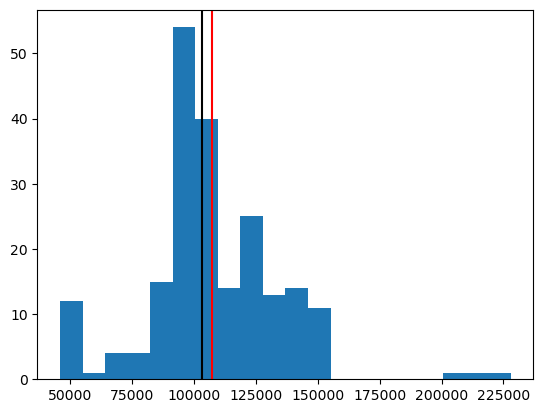

In [8]:
plt.hist(times, bins='auto')
plt.axvline(np.median(times), c= 'k')
plt.axvline(np.mean(times), c='r')
np.min(times), np.max(times)

Now compute the nesvorny impact probabilities for all of them, starting by importing the `collisions.txt` file:

((array([33., 36., 39., 29., 24., 22., 15.,  4.,  5.,  2.,  0.,  0.,  1.]),
  array([12.90623385, 14.68098352, 16.45573319, 18.23048287, 20.00523254,
         21.77998222, 23.55473189, 25.32948157, 27.10423124, 28.87898091,
         30.65373059, 32.42848026, 34.20322994, 35.97797961]),
  <BarContainer object of 13 artists>),
 12.90623384557009,
 18.789756680577,
 35.977979610585535)

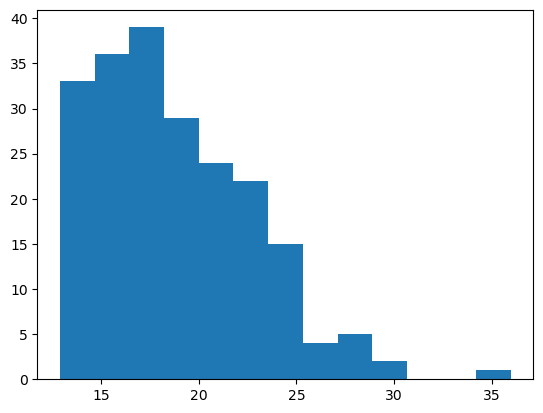

In [9]:
# Define regex patterns for Earth and asteroid velocities
earth_velocity_pattern = r"Earth velocity \[([-\deE., ]+)\]"
asteroid_velocity_pattern = r"Asteroid velocity \[([-\deE., ]+)\]"
asteroid_mass_pattern = r"Asteroid mass:?\s+([\deE.+-]+)"
asteroid_orb_elems_pattern = r"a ([\deE.+-]+), e ([\deE.+-]+), i ([\deE.+-]+), omega ([\deE.+-]+), Omega ([\deE.+-]+), M ([\deE.+-]+)"

# Lists to store velocities
earth_velocities = []
asteroid_velocities = []
asteroid_masses = []
asteroid_orb_elems = []

sun_total, mercury_total, venus_total, earth_total, mars_total, jupiter_total = np.zeros(6)

# Read the file and extract velocities
with open('./collisions.txt', 'r') as file:
    for line in file:
        # Check if line contains Earth or asteroid velocity or asteroid mass/orbital elements:
        earth_vel_match = re.search(earth_velocity_pattern, line)
        asteroid_vel_match = re.search(asteroid_velocity_pattern, line)
        asteroid_mass_match = re.search(asteroid_mass_pattern, line)
        asteroid_orb_elem_match = re.search(asteroid_orb_elems_pattern, line)
        # check if they match and if so extract them
        if earth_vel_match:
            earth_velocity = list(map(float, earth_vel_match.group(1).split(',')))
            earth_velocities.append(earth_velocity)
        if asteroid_vel_match:
            asteroid_velocity = list(map(float, asteroid_vel_match.group(1).split(',')))
            asteroid_velocities.append(asteroid_velocity)
        if asteroid_mass_match:
            asteroid_mass = float(asteroid_mass_match.group(1))
            asteroid_masses.append(asteroid_mass)
        if asteroid_orb_elem_match:
            asteroid_orb_elem = [float(asteroid_orb_elem_match.group(g)) for g in range(1, 7)]
            asteroid_orb_elems.append(asteroid_orb_elem)
        # match exactly, don't need regex here
        if 'Collision with the Sun' in line:
            sun_total += 1
        if 'Collision with Mercury' in line:
            mercury_total += 1
        if 'Collision with Venus' in line:
            venus_total += 1
        if 'Collision with Earth' in line:
            earth_total += 1
        if 'Collision with Mars' in line:
            mars_total += 1
        if 'Collision with Jupiter' in line:
            jupiter_total += 1
# assemble collisions into one array
col_counts = np.array([sun_total, mercury_total, venus_total, earth_total, mars_total, jupiter_total])
# convert to impact velocities by subtracting asteroid from earth velocities and taking the norm
# since this is in AU/yr, convert to km/s
auyr_kms = 4.744  # 1 AU/yr = 4.744 km/s
# compute impact velocities in km/s
impact_velocities = np.linalg.norm(np.array(asteroid_velocities) - np.array(earth_velocities), axis=1) * auyr_kms
# histogram
plt.hist(impact_velocities, bins='auto'), np.min(impact_velocities), np.mean(impact_velocities), np.max(impact_velocities)

In order: total initial particles, total final particles, total collision counts with the Sun, Mercury, Venus, Earth, Mars, and Jupiter in order, particles ejected beyond 10 AU

In [10]:
np.sum(init_N), np.sum(final_N), col_counts, int(np.sum(col_counts)), int(np.sum(init_N) - np.sum(final_N) - np.sum(col_counts))

(563512, 551109, array([700.,   5., 118., 210.,   9.,  45.]), 1087, 11316)

In [11]:
100 * col_counts/np.sum(col_counts)

array([64.3974241 ,  0.4599816 , 10.85556578, 19.31922723,  0.82796688,
        4.13983441])

Compute the secular impact probability of each impactor:

In [181]:
# constants for earth and sun
a0 = 1.  # semi-major axis of earth in au
m = 5.97e24  # mass of earth in kg
R = 4.259e-5  # radius of earth in au
M = 1.988e30  # mass of sun in kg
e0 = 0.01671123  # eccentricitiy of earth

compiler = 'gfortran'  # name of fortran compiler to use
# compile fortran code if it hasn't been already
subprocess.run([compiler, './Pokorny_et_al_2013/PROB_KOZAI_V001.f90', '-o', './Pokorny_et_al_2013/CODE', '-O3'])

# define function
def get_pokorny_annual_P_packed(aeiperi, a_earth=a0, e_earth=e0, R_earth=R):
    """
    Get the collisional probability using Petr Pokorny's 2013 code with a, e, i, peri packed as a tuple
    Takes in a given a, e, i and argument of pericenter of the projectile and returns the annual collisional probability

    a is in units of AU, i is in units of degrees, argument of pericenter is in degrees
    """
    a, e, i, peri = aeiperi  # unpack
    # run fortran code
    output = subprocess.run(['./Pokorny_et_al_2013/CODE', '<'], 
                            input=f'{a},{e},{i},{peri}\n{a_earth}\n{e_earth}'.encode('utf-8'), 
                            capture_output=True)
    # print(output)
    col_prob = np.float64(output.stdout.decode('utf-8').split()[-1]) * (R_earth ** 2)
    return col_prob

# orbital elements are given a, e, i, omega, Omega, M so extract the first four 
asteroid_aeiperis = np.array(asteroid_orb_elems)[:, 0:4]

# multiprocess and compute
pool = multiprocessing.Pool()
asteroid_pts = np.array(list(tqdm(pool.imap(get_pokorny_annual_P_packed, asteroid_aeiperis), total = len(asteroid_aeiperis))))
# join and close
pool.close()
pool.join()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 197/197 [01:42<00:00,  1.91it/s]


Plot $f_\mathrm{imp}$ vs. $q$ for the impactors and also compute impact energies and plot $f_\mathrm{imp}$ vs. impact energy

In [182]:
np.degrees(asteroid_aeiperis[:, 2])

array([ 2.76375238, 17.40134838, 18.83948873, 19.59083406, 28.82863171,
       21.82597894, 28.81467169, 12.88320916, 31.60120323, 26.53206085,
       28.50821485, 21.48254645, 18.94526365, 13.17319063, 43.87003743,
       12.74371302, 19.33334045, 32.51652403, 14.42428291,  1.67741385,
        6.40535009, 10.35954564, 24.71454552,  0.98692978,  3.11391573,
       15.64950633, 12.16436522, 22.26625135, 28.48162789,  6.26161664,
        9.86916457, 39.51852335, 25.40331793, 26.88696171, 27.70925369,
        2.65569681, 15.84449548,  0.33015969, 15.27781339, 33.49467197,
       26.62194386, 33.88481966, 24.0796538 , 30.17584023, 18.64622067,
       20.64447137, 45.58841418, 25.91629688, 29.15562818, 18.40648445,
       27.05428243, 10.90081841, 28.32923046, 16.11070191, 22.52459113,
        4.49179376, 18.94864674, 10.82858462,  8.65382415, 27.42165628,
       11.51679325, 12.69964115, 38.4184958 , 34.74041217, 21.58909687,
       19.09807177, 30.6836476 , 26.09415431, 15.68085207,  2.92

In [183]:
asteroid_aeiperis[:, 0]

array([   3.23721329,    2.8506827 ,    1.31471186,    3.09212945,
          2.15681404,    1.46616759,    1.98685047,   26.89932955,
          1.10344845,    0.69997699,    2.1171234 ,    3.50430147,
          1.73397754,    3.69979356,    1.24130143,    2.78008299,
          1.57304806,    2.00492704,    1.45585304,    1.49353682,
          5.21683811,    1.88512299,    1.51654916,    2.13282277,
          4.24081881,    6.28091869,  -15.1327099 ,    2.55468092,
          2.87683147,    4.45534625,    6.21085351,    1.66488273,
          1.72552563,    4.79379162,    1.90789508,    2.52534203,
          4.69778339,    0.89492492,    2.85357117,    2.7111701 ,
          2.10730697,    1.38731432,    1.89343894,    0.8190924 ,
          2.12155677,    3.58104913,    0.94510919,    1.79070975,
          1.84514727,    1.00425991,    2.42569642,   33.82453944,
          1.28801748,    2.20264659,    0.72814423,    0.69698193,
          1.90259645,   14.55991203,    1.35467484,    1.52645

array([1.28839889e-07, 2.81965832e-08, 6.68988072e-08, 2.57753648e-08,
       2.84551710e-08, 5.60350512e-08, 5.25961821e-08, 1.32748015e-08,
       5.17835589e-08, 2.68582049e-07, 6.71770309e-08, 1.33556591e-08,
       4.92181096e-08, 2.08279782e-08, 3.42036568e-08, 3.25593698e-08,
       5.22732496e-08, 3.50123883e-08, 7.66414480e-08, 6.36058506e-07,
       2.42915103e-08, 7.07110005e-08, 4.31081989e-08, 6.41797507e-07,
       7.23693118e-08, 1.21570680e-08, 0.00000000e+00, 2.33968976e-08,
       1.46973874e-08, 5.65025643e-08, 2.31247885e-08, 3.57835788e-08,
       3.36598840e-08, 7.55328043e-09, 2.58908909e-08, 1.76587147e-07,
       1.20577736e-08,            nan, 6.87141769e-08, 2.28201373e-08,
       2.82312221e-08, 3.53117406e-08, 3.09780212e-08, 1.10028712e-07,
       4.01615038e-08, 3.92727446e-08, 4.74817914e-08, 3.53366389e-08,
       7.26779877e-08, 1.07742239e-07, 2.08695119e-08, 1.72987325e-09,
       4.57271186e-08, 3.84446442e-08, 2.50507340e-07, 1.46875400e-06,
      

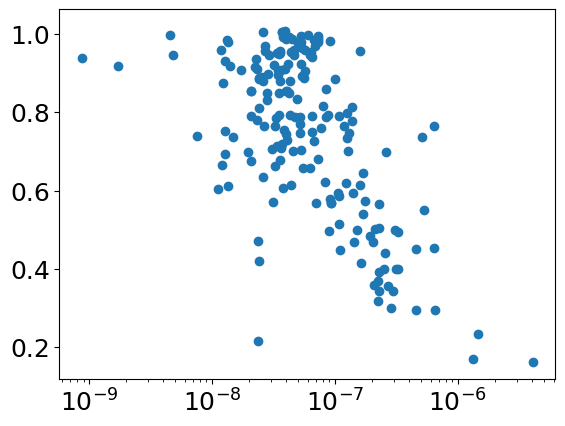

In [184]:
asteroid_qs = asteroid_aeiperis[:, 0] * (1. - asteroid_aeiperis[:, 1])
plt.scatter(asteroid_pts, asteroid_qs)  # a * (1. - e)
plt.xscale('log')
asteroid_pts

(Text(0.5, 0, 'Energy (kT TNT)'),
 Text(0, 0.5, 'Impact Probability (yr$^{-1}$)'))

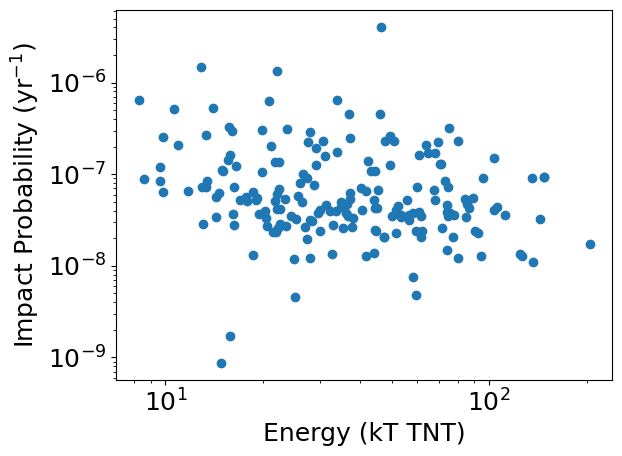

In [185]:
# convert km/s to m/s and then convert from J to kT TNT
kttnt_j = 4.18e12  # conversion factor for kt tnt to joules
impact_energies = (((impact_velocities[-len(asteroid_masses):] * 1000.) ** 2) * np.array(asteroid_masses))/(2. * kttnt_j)
plt.rc('font', size=18)
plt.figure()
plt.scatter(impact_energies, asteroid_pts)
plt.xscale('log'), plt.yscale('log')
plt.xlabel('Energy (kT TNT)'), plt.ylabel(r'Impact Probability (yr$^{-1}$)')

### Million dollar plot:

For each set of impactor energies and fluxes, plot as a separate series with a separate colour in matplotlib:

In [14]:
from matplotlib.ticker import StrMethodFormatter

# get index of all the columns with energy
energy_indices = [imp_flux_energy.columns.get_loc(col) for col in imp_flux_energy.columns if 'Energy (kT)' in col]

# font
# plt.rc('font', size=30)
fsize=44
plt.rc('font', size=fsize)

# plot figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (24, 22), dpi=800)
for j, ind in enumerate(energy_indices): 
    # plot the brown 2002, silber 2009 and brown 2013 curves together, removing the last two pionts
    # brown 2002 and silber 2009
    if ind in [0, 3]:
        plt.scatter(imp_flux_energy.iloc[:, ind], imp_flux_energy.iloc[:, ind + 1], label = 'Fireball/Acoustic', c='g', marker='o', s=200)
    # brown 2013
    elif ind == 6:
        # plt.errorbar(imp_flux_energy.iloc[:,ind], imp_flux_energy.iloc[:, ind + 1], 
        #              yerr = imp_flux_energy.iloc[:, ind + 2], label = 'Fireball/Acoustic', c='r', fmt='o', capsize=5)
        plt.scatter(imp_flux_energy.iloc[:, ind], imp_flux_energy.iloc[:, ind + 1], label = 'Fireball/Acoustic', c='g', marker='o', s=200)
    # plot the other points as telescopic data:
    else:
        pass
        # plt.scatter(imp_flux_energy.iloc[:, ind], imp_flux_energy.iloc[:, ind + 1], label = 'Pre-2018 Telescopic', c='r', marker='o', s=120)
# impact probability for H = 28 (~7.9 m with albedo a = 0.18) is 2.6e-3 Myr^-1 given by Nesvorny et al. 2023
impact_prob = 2.6e-3 * 1e-6  # converting from Myr^-1 to yr^-1
# plot the nesvorny, harris and chodas, and heinze points:
plt.scatter(nesvorny_es, nesvorny_n * impact_prob, label = 'Nesvorný et al. (2023)', marker='s', c='fuchsia', s=200)
plt.scatter(hc_es, hc_n * impact_prob, label = 'Harris and Chodas (2021)', marker='s', c='cyan', s=200)
plt.scatter(heinze_es, heinze_n * impact_prob, label = 'Heinze et al. (2021)', marker='s', c='black', s=200)

# add our point!
# uncertainty introduced by bulk density

### UPDATE UNCERTAINTIES PER PETER'S NOTE
# Removed X-uncertainty (the 10-m bin with width based on how we define decameter objects)
# Changed the Y-uncertainty to be Poisson uncertainty only (remove the uncertainty introduced by bulk density)

# plt.errorbar(mean_energy, flux, yerr=np.array([flux - flux_density_lb, flux_density_ub - flux])[:, None], 
#              xerr=np.array([mean_energy - energy_lb, energy_ub - mean_energy])[:, None], fmt='o', capsize=10, c='r', markersize=20)

# statistical (Poisson) uncertainty

# Compute confidence interval of the flux
confidence_interval = 0.68  # 1 sigma

ci = 1.0 - confidence_interval
num_ci_lower = scipy.stats.chi2.ppf(ci/2, 2*flux)/2
num_ci_upper = scipy.stats.chi2.ppf(1 - ci/2, 2*(flux + 1))/2

# plt.errorbar(mean_energy, flux, yerr=np.array([0., np.sqrt(flux)])[:, None], 
#              xerr=np.array([mean_energy - energy_lb, energy_ub - mean_energy])[:, None], fmt='o', capsize=10, c='r', markersize=20)
plt.errorbar(mean_energy, flux, yerr=np.array([np.sqrt(flux)/np.sqrt(n_events), np.sqrt(flux)/np.sqrt(n_events)])[:, None], 
             xerr=None, fmt='o', capsize=10, c='r', markersize=30)

plt.scatter(impact_energies, asteroid_pts, marker='o', c='darkorange', s=200)

# set xlim, ylim to same values used in figure
xmin, xmax = 1e-2, 1e4
ymin, ymax = 1e-4, 1e2
# x, ylim
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# label axes
plt.xlabel('Bolide Energy (kT TNT)', fontsize=fsize + 6, labelpad=20)
plt.ylabel('Cumulative number impacting Earth per year',fontsize=fsize+6, labelpad=25)
# set x, y ticks
ax1.set_xticks(ticks=np.geomspace(xmin, xmax, int(np.log10(xmax) - np.log10(xmin) + 1)), minor=False)
ax1.set_yticks(ticks=np.geomspace(ymin, ymax, int(np.log10(ymax) - np.log10(ymin) + 1)), minor=False)
# log scale
ax1.set_xscale('log'), ax1.set_yscale('log')
# show grid
plt.grid()
# add second axis for diameter
diameter_lamb = lambda e, v=20., rho=1500.: get_diameter(v, e, rho)
energy_lamb = lambda d, v=20., rho=1500.: get_energy(v, d, rho)
ax2 = ax1.secondary_xaxis('top', functions=(diameter_lamb, energy_lamb))
# # and set ticks and label size
ax2_xmin = get_diameter(20., xmin, 1500.)
ax2_xmax = get_diameter(20., xmax, 1500.)
ax2.set_xlim(ax2_xmin, ax2_xmax)
ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax2.set_xlabel('Diameter (m)', fontsize=fsize + 6, labelpad=15)
# make ticks bigger
ax1.tick_params('both', length=30, width=4, which='major')
ax1.tick_params('both', length=16, width=2, which='minor')
ax2.tick_params('both', length=30, width=4, which='major')
ax2.tick_params('both', length=16, width=2, which='minor')
# legend
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
lgnd = plt.legend(by_label.values(), by_label.keys(), fontsize=fsize+8, loc='lower left')
# set the sizes
lgnd.legend_handles[0]._sizes = [250]
lgnd.legend_handles[1]._sizes = [250]
lgnd.legend_handles[2]._sizes = [250]
lgnd.legend_handles[3]._sizes = [250]
# tight layout
plt.tight_layout()
# save
# plt.savefig('lpsc_plots/impactor_flux_energy.png')
plt.savefig('dda_talk_plots/impactor_flux_energy.png')